In [1]:
import os
import cbclib as cbc
import numpy as np
# import jax
# import jax.numpy as jnp
import sys
import hdf5plugin
import h5py
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider
from pickle import load, dump
from cbclib.src import draw_line_table, fft_convolve, local_maxima, median

from scripts.cbsd_numpy import (generate_line, region_grow, Structure, log_nfa,
                                find_streaks, DetState, Image)

In [2]:
frame = np.load("results/test_frame.npy")
mask = np.load("results/test_mask.npy")

In [3]:
regions = cbc.src.label(frame, (frame > 3) & mask, cbc.src.Structure(9, 6), 30)
regions = cbc.src.filter(frame.shape, regions, cbc.src.Structure(1, 1), 5)

In [7]:
centers = cbc.src.center_of_mass(regions, frame)
fits = cbc.src.ellipse_fit(regions, frame)

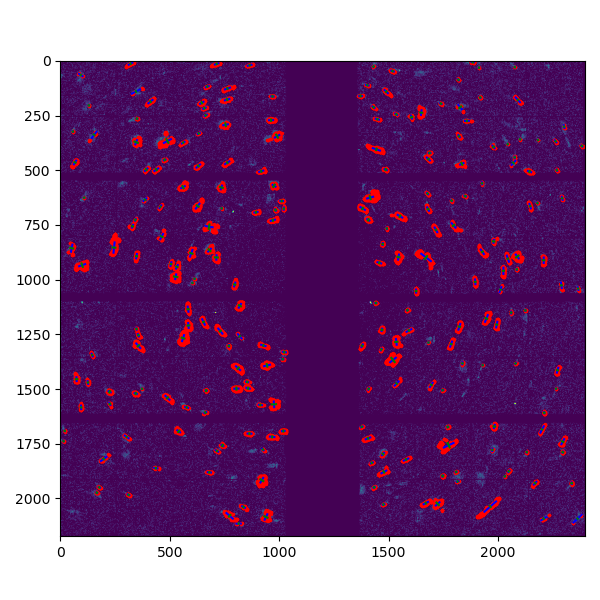

In [20]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frame, vmin=0, vmax=5)
for ctr, fit, region in zip(centers, fits, regions):
    ax.scatter(region.x, region.y, s=2, c='r')
    ax.plot([ctr[0] - np.cos(fit[2]) * fit[0], ctr[0] + np.cos(fit[2]) * fit[0]],
            [ctr[1] - np.sin(fit[2]) * fit[0], ctr[1] + np.sin(fit[2]) * fit[0]], c='b')
    ax.plot([ctr[0] + np.sin(fit[2]) * fit[1], ctr[0] - np.sin(fit[2]) * fit[1]],
            [ctr[1] - np.cos(fit[2]) * fit[1], ctr[1] + np.cos(fit[2]) * fit[1]], c='g')

fig.tight_layout()
plt.show()

## C++ implementation

In [2]:
frames = np.load('results/frames.npz')['data']

In [3]:
from cbclib.streak_finder import Pattern

struct = cbc.src.Structure(4, 4)
data = frames[5]
mask = np.any(frames != 0.0, axis=0)

pattern = Pattern(data, mask, struct)

In [4]:
peaks = pattern.find_peaks(1.2, 10)
peaks

<Peaks, points = <Points, size = 2339>>

In [7]:
lines = pattern.find_streaks(peaks, xtol=2.5, vmin=1.0, lookahead=3, min_size=2)

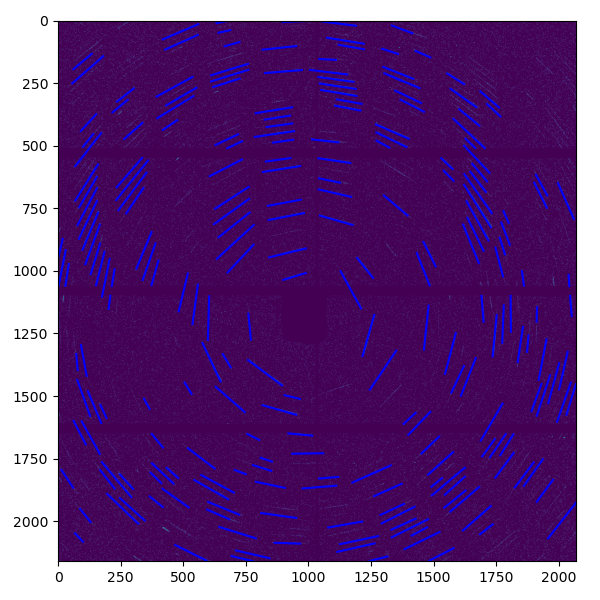

In [8]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(data, vmin=0.0, vmax=10.0)
# ax.scatter(peaks.points.x, peaks.points.y, c='r', s=1)

for line in lines:
    ax.plot(line[::2], line[1::2], c='b')

ax.set_xlim(0, pattern.shape[1])
ax.set_ylim(pattern.shape[0], 0)

fig.tight_layout()
plt.show()

In [12]:
regions = cbc.src.label(data, data > 3, cbc.src.Structure(4, 4), 50)

In [13]:
centers = np.array(cbc.src.center_of_mass(regions, data))

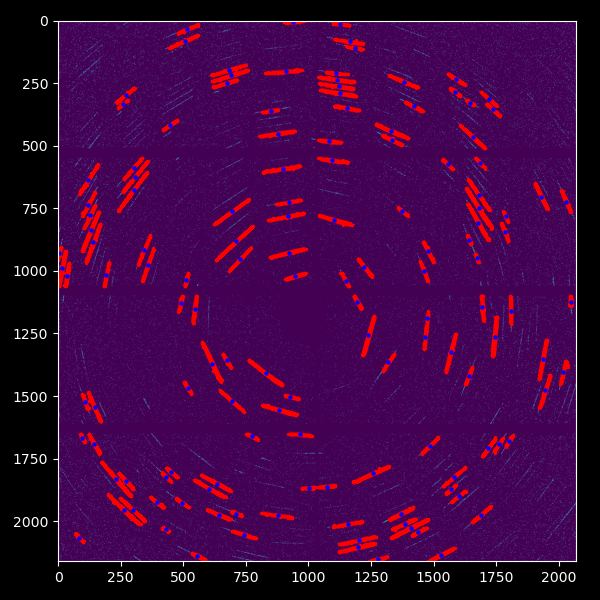

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(data > 3, vmin=0.0, vmax=1.0)
for region in regions:
    ax.scatter(region.x, region.y, c='r', s=2)

ax.scatter(centers[:, 0], centers[:, 1], c='b', s=5)

ax.set_xlim(0, pattern.shape[1])
ax.set_ylim(pattern.shape[0], 0)

fig.tight_layout()
plt.show()

In [5]:
struct = Structure.new(radius=2, rank=2)
image = Image.new(data, struct)

In [7]:
idx = 230
x, y = 548, 1137
# x, y = peaks.x[idx], peaks.y[idx]
xtol, vmin = 1.2, 0.8

In [8]:
%time line = region_grow(x, y, image, 50, xtol, vmin, lookahead=1)

CPU times: user 38.8 ms, sys: 6.91 ms, total: 45.7 ms
Wall time: 39.8 ms


In [9]:
line2 = cbc.src.test_grow(x, y, data, mask, cbc.src.Structure(4, 4), 2.6, 0.5, 50, lookahead=3)
line2

point = 

[558.2912231562208, 1053.6393120657406, 537.3145102755159, 1211.1750339814546]

{558, 1054}
point = {558, 1055}
point = {558, 1056}
point = {558, 1057}
point = {558, 1058}
point = {558, 1059}
point = {557, 1060}
point = {557, 1061}
point = {557, 1062}
point = {557, 1063}
point = {557, 1064}
point = {557, 1065}
point = {557, 1066}
point = {557, 1067}
point = {556, 1068}
point = {556, 1069}
point = {556, 1070}
point = {556, 1071}
point = {556, 1072}
point = {556, 1073}
point = {556, 1074}
point = {555, 1075}
point = {555, 1076}
point = {555, 1077}
point = {555, 1078}
point = {555, 1079}
point = {555, 1080}
point = {555, 1081}
point = {555, 1082}
point = {554, 1083}
point = {554, 1084}
point = {554, 1085}
point = {554, 1086}
point = {554, 1087}
point = {554, 1088}
point = {554, 1089}
point = {553, 1090}
point = {553, 1091}
point = {553, 1092}
point = {553, 1093}
point = {553, 1094}
point = {553, 1095}
point = {553, 1096}
point = {553, 1097}
point = {552, 1098}
point = {552, 1099}
point = {552, 1100}
point = {552, 1101}
point = {552, 1102}
point = {552, 1103}
point = 

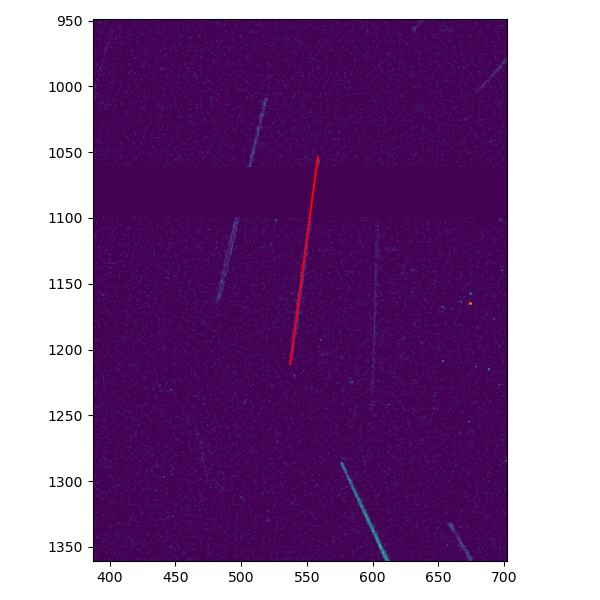

In [10]:
%matplotlib widget
offset = 150

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0.0, vmax=30)
# ax.scatter(points[0, 1], points[0, 0], c='r')
# ax.scatter(line.pixels.x, line.pixels.y, s=3, alpha=0.5, c='r')

ax.plot([line.bounds.x0, line.bounds.x1], [line.bounds.y0, line.bounds.y1], c='b')
ax.plot(line2[::2], line2[1::2], c='r')

ax.scatter(674, 1157, s=1)
ax.scatter(674, 1165, s=1)

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()

## Python implementation

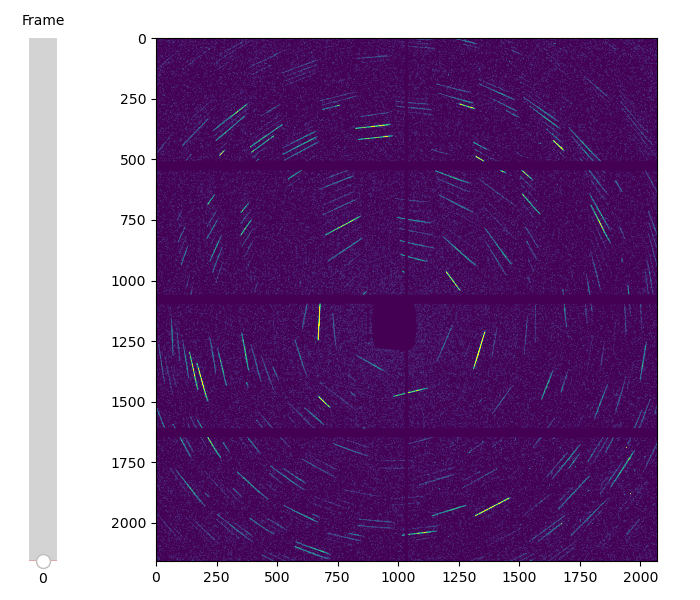

In [3]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=frames.shape[0],
                valstep=np.arange(0, frames.shape[0]),
                valinit=0, orientation="vertical")

im = ax[1].imshow(frames[0], vmin=0.0, vmax=5.0)

def update(val):
    im.set_data(frames[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

In [4]:
index = 18
radius, rank = 2, 3

data = cbc.src.median_filter(frames[index], (3, 3))
# data = frames[index]
data = np.abs(data)
struct = Structure.new(radius, rank)

image = Image.new(data, struct)

In [55]:
xtol, vmin = 1.0, 0.8

# x, y = 1153, 1057
x, y = 1831, 1410
# x, y = 1514, 1262

%time line = region_grow(x, y, image, 200, xtol, vmin, lookahead=1)
# %time x, y, val = cbc.src.draw_line_table(line.bounds.to_line(2 * struct.radius + 1), image.shape, profile='tophat')
# %time image.update(struct, x, y, val)
# x, y = 1750, 660
# x, y = 1862, 1296

# %time line = region_grow(x, y, image, 200, xtol)

CPU times: user 93.2 ms, sys: 3.16 ms, total: 96.4 ms
Wall time: 90.7 ms


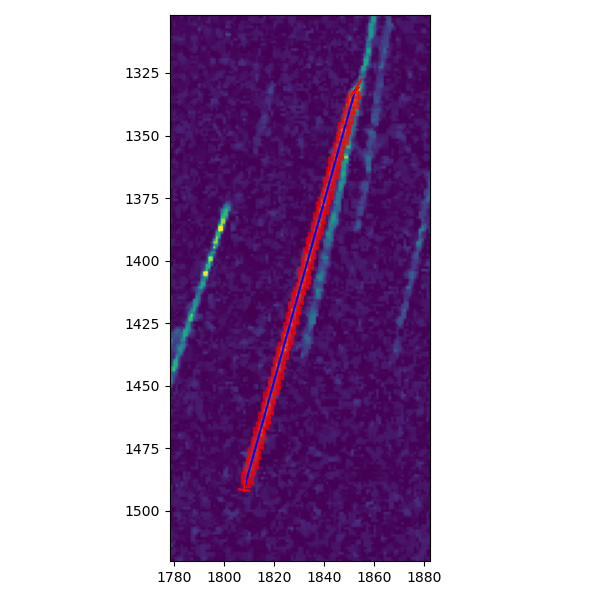

In [56]:
fline = generate_line(int(np.round(line.bounds.x0)), int(np.round(line.bounds.y0)),
                      image, struct.idxs)
fline2 = generate_line(int(np.round(line.bounds.x0 - np.cos(line.bounds.theta) * (radius + 0.5))),
                       int(np.round(line.bounds.y0 - np.sin(line.bounds.theta) * (radius + 0.5))),
                       image, struct.idxs)
bline = generate_line(int(np.round(line.bounds.x1)), int(np.round(line.bounds.y1)),
                         image, struct.idxs)
bline2 = generate_line(int(np.round(line.bounds.x1 + np.cos(line.bounds.theta) * (radius + 0.5))),
                       int(np.round(line.bounds.y1 + np.sin(line.bounds.theta) * (radius + 0.5))),
                       image, struct.idxs)

%matplotlib widget
offset = 30

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0.0, vmax=10)
ax.scatter(line.pixels.x, line.pixels.y, s=3, alpha=0.5, c='r')

ax.plot([line.bounds.x0, line.bounds.x1], [line.bounds.y0, line.bounds.y1], c='b')
ax.plot([fline.bounds.x0, fline.bounds.x1], [fline.bounds.y0, fline.bounds.y1], c='r')
ax.plot([fline2.bounds.x0, fline2.bounds.x1], [fline2.bounds.y0, fline2.bounds.y1], c='r')
ax.plot([bline.bounds.x0, bline.bounds.x1], [bline.bounds.y0, bline.bounds.y1], c='r')
ax.plot([bline2.bounds.x0, bline2.bounds.x1], [bline2.bounds.y0, bline2.bounds.y1], c='r')

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()

In [4]:
from copy import deepcopy

index = 18
radius, rank = 2, 3
struct = Structure.new(radius=radius, rank=rank)

data = frames[index]
# data = cbc.src.median_filter(frames[index], (3, 3))
new_image = Image.new(np.clip(data, 0.0, np.inf), struct)
# new_image = Image.new(np.abs(data), struct)

In [25]:
image = deepcopy(new_image)

In [26]:
state = DetState.new_sparse(image, axis=1)

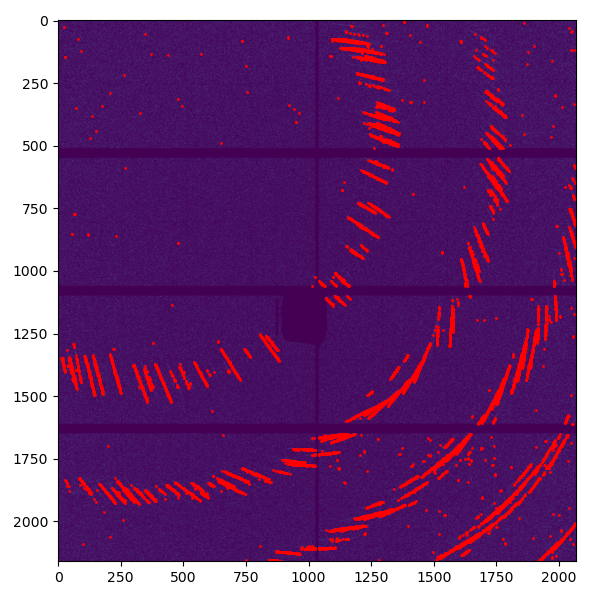

In [27]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image.data[()], vmin=0, vmax=10)
ax.scatter(state.x, state.y, s=1, c='r')

fig.tight_layout()
plt.show()

In [28]:
state = find_streaks(image, state, xtol=1.1, lookahead=2, min_size=5)

Detecting lines: 0 checked [00:00, ?it/s]

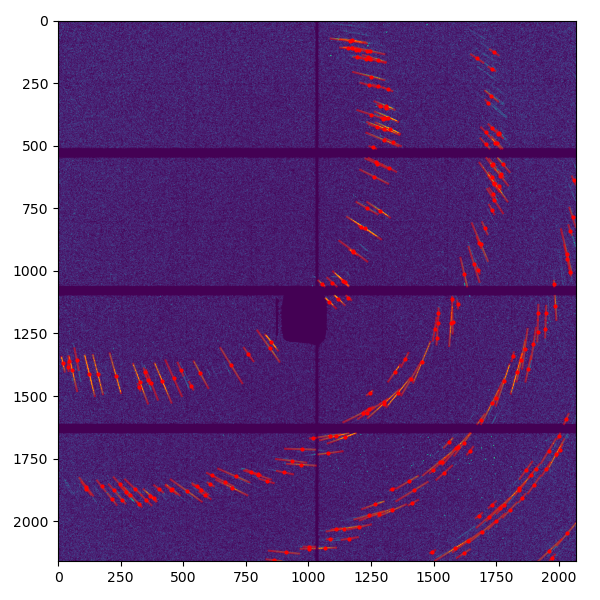

In [29]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(new_image.data[()], vmin=0, vmax=5)
for line in state.lines:
    ax.plot(line.bounds.x, line.bounds.y, c='r', alpha=0.5)
    ax.scatter(line.pixels.x0, line.pixels.y0, c='r', s=4)

ax.set_ylim(data.shape[0], 0)
ax.set_xlim(0, data.shape[1])
fig.tight_layout()
plt.show()

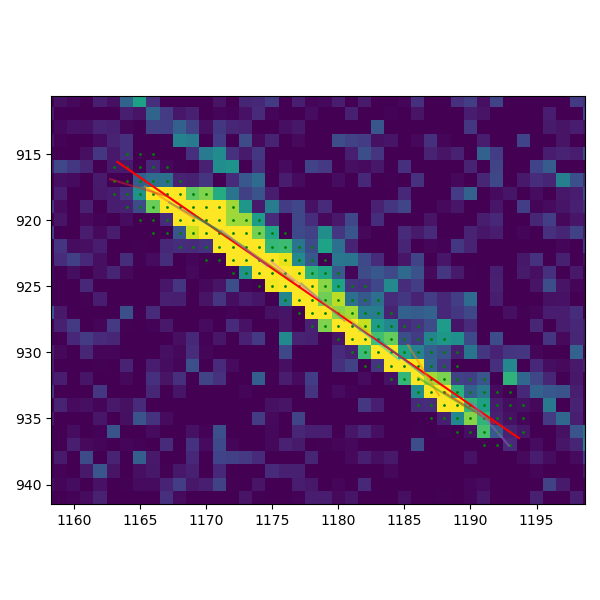

In [9]:
line = state.lines[1]
offset = 5

%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frames[index], vmin=0, vmax=10)
ax.plot(line.bounds.x, line.bounds.y, c='r')
ax.scatter(line.pixels.x, line.pixels.y, c='g', s=1)
for seed in line.linelets:
    ax.plot(seed.x, seed.y, alpha=0.5)

ax.set_ylim(max(line.bounds.y0, line.bounds.y1) + offset,
            min(line.bounds.y0, line.bounds.y1) - offset)
ax.set_xlim(min(line.bounds.x0, line.bounds.x1) - offset,
            max(line.bounds.x0, line.bounds.x1) + offset)
fig.tight_layout()
plt.show()